In [1]:
%matplotlib inline

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from mountaincar import MountainCar, MountainCarViewer

In [ ]:
np.seterr(over='raise')

In [4]:
car = MountainCar()

### Plot functions

In [15]:
def vec_plot(p):
    p_max = np.argmax(p, axis=2)
    U = (p_max == 0) * 1 + (p_max == 1) * -1
    V = np.zeros((ngrid_pos, ngrid_speed))
    
    plt.quiver(U, V, alpha=1, scale=1.8, units='xy')

    plt.xlim(-1, 20)
    plt.xticks(())
    plt.ylim(-1, 20)
    plt.yticks(())
    
    plt.xlabel('position $x$')
    plt.ylabel('speed $\dot x$')
    plt.title('Q-values direction vector field (arrows show the direction of applied force)')

    plt.show()

In [16]:
def plot3D(q):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x, y = np.meshgrid(x_pos, y_speed)
    ax.plot_wireframe(x, y, q, color='grey')
    ax.set_xlabel('position')
    ax.set_ylabel('speed')
    ax.set_zlabel('max q')
    
    plt.show()

### Helper coordinates

In [5]:
# grid discretisation
ngrid_pos = 20
ngrid_speed = 20

In [6]:
# grid corners
int_pos = -150, 30
int_speed = -15, 15

In [10]:
x_pos, center_dist_pos = np.linspace(int_pos[0], int_pos[1], ngrid_pos, retstep=True)
y_speed, center_dist_speed = np.linspace(int_speed[0], int_speed[1], ngrid_speed, retstep=True)
y_speed_t = y_speed.reshape(-1, 1)

### Helper functions

In [11]:
def activity(s):
    return np.exp(- ((x_pos - s[0]) / center_dist_pos) ** 2 - ((y_speed_t - s[1]) / center_dist_speed) ** 2).T

In [12]:
def Q(s, a, w):
    return np.sum(w[:, :, a] * activity(s))

In [13]:
# This is a robust solution so that we have a meaningful value for tau.
def softmax(x, tau):
    
    # all zero mean 1/len(x) chance for each action
    if np.count_nonzero(x) == 0:
        return np.ones_like(x) / len(x)
    
    # rescale to avoid overflow issues
    xp = (np.array(x) - np.min(x)) / (np.max(x) - np.min(x))
    
    e_x = np.exp(xp / tau)
    return e_x / e_x.sum()

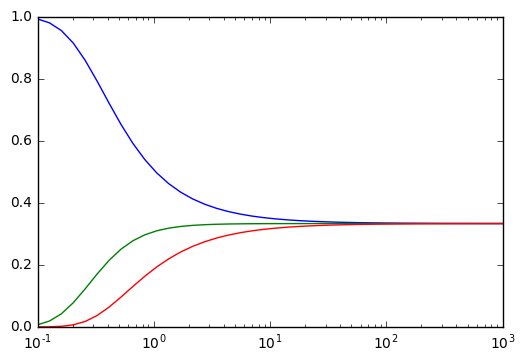

In [14]:
qs = np.array([0.3, 0.2, 0.1])
x = np.logspace(-1, 3, 40)
y = np.array(list(zip(*[softmax(qs, xi) for xi in x])))

plt.xscale("log")
plt.plot(x,y[0])
plt.plot(x,y[1])
plt.plot(x,y[2])
plt.show()

In [17]:
def sarsa(tau=1, # exploration/expoitation parameter
          gamma=0.95, 
          lmbda = 0.8, 
          eta = 0.002, 
          dt=0.01, 
          steps=100):
    
    probs = []
    times = []

    # initial random weights
    w = np.zeros((ngrid_pos, ngrid_speed, 3))

    i = 0
    for epi in np.arange(1000):
        print("episode :", epi)

        # null eligibility traces
        e = np.zeros((ngrid_pos, ngrid_speed, 3))

        # initial state
        car.reset()
        s0 = car.x, car.x_d

        # initial random action
        a0 = np.random.randint(3)

        j = 0
        while True:
            i += 1
            j += 1

            # take action between -1, 0 and 1
            car.apply_force(a0 - 1)
            car.simulate_timesteps(steps, dt)

            # retrieve current state and closest discret state
            s1 = car.x, car.x_d

            # compute proba for each action and choose among them
            p = softmax([Q(s1, a, w) for a in range(3)], tau)
            a1 = np.random.choice(range(3), p=p)

            # decrease eligibility traces and increase selection action
            e *= gamma * lmbda
            e[:, :, a0] += activity(s0)[:, :]

            # update weights
            delta = car.R + gamma * Q(s1, a1, w) - Q(s0, a0, w)
            w += eta * delta * e

            # propagate next action and state
            a0 = a1
            s0 = s1

            if car.R > 0.0:
                print('reward obtained at t =', car.t)
                break

        prob = np.array([[softmax([Q((x, y), a, w) for a in range(3)], tau) for x in x_pos] for y in y_speed])
        max_action = np.max([[[Q((x, y), a, w) for a in range(3)] for x in x_pos] for y in y_speed], axis=2)

        #vec_plot(prob)
        #plot3D(max_action)
        #plt.show()

        probs.append(prob)
        times.append(car.t)
    return w, probs, times

episode : 0
reward obtained at t = 4237.0
episode : 1
reward obtained at t = 222.0
episode : 2
reward obtained at t = 321.0
episode : 3
reward obtained at t = 604.0
episode : 4
reward obtained at t = 487.0
episode : 5
reward obtained at t = 244.0
episode : 6
reward obtained at t = 184.0
episode : 7
reward obtained at t = 170.0
episode : 8
reward obtained at t = 163.0
episode : 9
reward obtained at t = 304.0
episode : 10
reward obtained at t = 192.0
episode : 11
reward obtained at t = 211.0
episode : 12
reward obtained at t = 236.0
episode : 13
reward obtained at t = 175.0
episode : 14
reward obtained at t = 162.0
episode : 15
reward obtained at t = 194.0
episode : 16
reward obtained at t = 94.0
episode : 17
reward obtained at t = 178.0
episode : 18
reward obtained at t = 192.0
episode : 19
reward obtained at t = 163.0
episode : 20
reward obtained at t = 232.0
episode : 21
reward obtained at t = 97.0
episode : 22
reward obtained at t = 88.0
episode : 23
reward obtained at t = 384.0
epis

KeyboardInterrupt: 

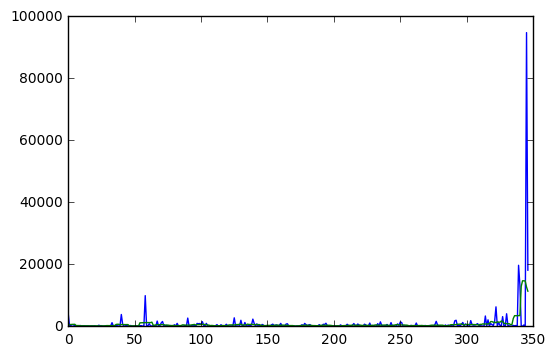

In [18]:
smooth = 10
plt.plot(times)
plt.plot(np.convolve(np.ones(smooth) / smooth, times, mode='same'))